In [7]:
import math
import numpy as np
from gymnasium.utils import seeding
import matplotlib.pyplot as plt
import cv2

import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 100

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)
    
class VAE(nn.Module):
    def __init__(self, image_channels=1, h_dim=1024, z_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).to(device)
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

In [9]:
CHECKPOINTS = 12
SCALE       = 6.0
TRACK_RAD   = 900/SCALE
TRACK_TURN_RATE = 0.31
TRACK_DETAIL_STEP = 21/SCALE
PLAYFIELD   = 2000/SCALE # Game over boundary

IMG_SIZE = 64  # Pixels

np_random, seed = seeding.np_random(None)

# Load VAE model
vae = VAE(z_dim=24).to(device) # GPU
vae.load_state_dict(torch.load("vae_64x64_24.pt"))

<All keys matched successfully>

In [10]:
import alphashape

def get_control_points_from_image(img):
    """Image must have uint8 values from 0 to 255"""
    
    # Sharpen image
    kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
    img = cv2.filter2D(img, -1, kernel)
    img = np.where(img < 30, 0, img)

    y, x = np.where(img != 0)
    # Calculate center
    center = [int(x.mean()), int(y.mean())]
    points_2d = np.array([x,y]).T
    # Fill contour
    for point in points_2d:
        cv2.line(img, point, center, color=255, thickness=1)
    points_2d = np.array(np.where(img > 100)).T
    # Get alpha shape
    alpha_shape = alphashape.alphashape(points_2d, alpha=0.6)
    geom_type = alpha_shape.geom_type
    alpha = 0.6
    while geom_type == "MultiPolygon":
        alpha -= 0.01
        alpha_shape = alphashape.alphashape(points_2d, alpha=alpha)
        geom_type = alpha_shape.geom_type

    points = np.array([xy for xy in alpha_shape.exterior.coords])
    points = fit_spline(points, num_points=300)

    return points*350/IMG_SIZE


import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

def fit_spline(points, num_points=200):
    # Linear length along the line:
    distance = np.cumsum( np.sqrt(np.sum( np.diff(points, axis=0)**2, axis=1 )) )
    distance = np.insert(distance, 0, 0)/distance[-1]

    # Build a list of the spline function, one for each dimension:
    splines = [UnivariateSpline(distance, coords, k=5, s=10) for coords in points.T]

    # Computed the spline for the asked distances:
    alpha = np.linspace(0, 1, num_points)
    points_fitted = np.vstack([spl(alpha) for spl in splines]).T

    return points_fitted

def plot_track(track, checkpoints=None):
    # Plot track
    plt.plot(track[:,1], track[:,0], linewidth=9, color=[0.4, 0.4, 0.4])
    plt.plot([track[0,1], track[-1,1]], [track[0,0], track[-1,0]], linewidth=9, color=[0.4, 0.4, 0.4])

    # Plot checkpoints
    if checkpoints is not None:
        for i in range(len(checkpoints)):
            y, x = checkpoints[i,:]
            plt.plot(x, y, 'o', markersize=2, color="tab:orange")
            plt.text(x, y, str(i), fontsize=10, color="black")
    
    plt.xlim(-20,360)
    plt.ylim(-20,360)

    ax = plt.gca()
    ax.set_facecolor(np.array([102, 230, 102])/255.)

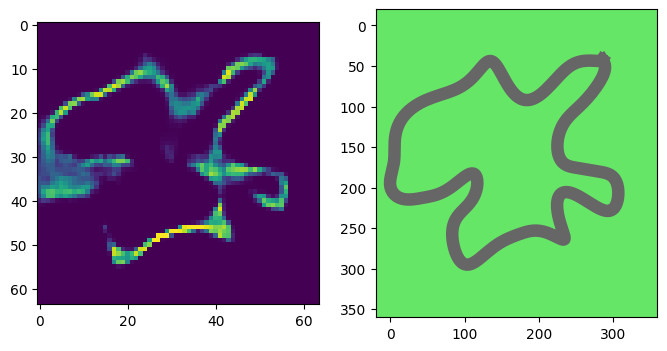

In [12]:
# Reconstruct image from latent space vector
noise = torch.randn(1, 24).to(device)
recon_x = vae.decode(noise).to('cpu').detach().numpy().squeeze()
#Get control points from image
recon_x = (recon_x*255).astype(np.uint8)
control_points = get_control_points_from_image(recon_x)
x, y = control_points[:,0], control_points[:,1]

# Plot track & image
plt.figure(figsize=(8,4))

plt.subplot(121)
plt.imshow(recon_x)

plt.subplot(122)
plot_track(np.array([x, y]).T)
plt.gca().invert_yaxis()

In [13]:
def generate_track(vae, vector=None):
    """Generate track from a latent space vector"""
    # Reconstruct image from latent space vector
    if vector is None:
        vector = torch.randn(1, 24).to(device)
    recon_x = vae.decode(vector).to('cpu').detach().numpy().squeeze()
    #Get control points from image
    recon_x = (recon_x*255).astype(np.uint8)
    track = get_control_points_from_image(recon_x)

    return track

In [17]:
import argparse
import importlib
import os
import random
import time
from distutils.util import strtobool

import gymnasium as gym
import numpy as np
import supersuit as ss
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.normal import Normal
from torch.distributions.categorical import Categorical
from torch.utils.tensorboard import SummaryWriter

from gym_multi_car_racing import multi_car_racing, multi_car_racing_f1, multi_car_racing_bezier
from vector.vector_constructors import concat_vec_envs

def make_env():

    # env setup
    if track_name is None:
        env = multi_car_racing_bezier.parallel_env(n_agents=num_agents, use_random_direction=False,
                                render_mode="human", discrete_action_space=discrete_actions, verbose=1)
    else:
        print("Track:", track_name)
        env = multi_car_racing_f1.parallel_env(n_agents=num_agents, use_random_direction=False,
                                render_mode="state_pixels", discrete_action_space=discrete_actions,
                                track=track_name, verbose=1)
    
    if not discrete_actions:
        env = ss.clip_actions_v0(env)
    if frame_skip > 1:
        env = ss.frame_skip_v0(env, frame_skip)
    if frame_stack > 1:
        env = ss.frame_stack_v1(env, frame_stack)
    env = ss.pettingzoo_env_to_vec_env_v1(env)

    return env


def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer


class Agent(nn.Module):
    def __init__(self, envs):
        super().__init__()
        self.network = nn.Sequential(
            layer_init(nn.Conv2d(12, 32, 8, stride=4)),
            nn.ReLU(),
            layer_init(nn.Conv2d(32, 64, 4, stride=2)),
            nn.ReLU(),
            layer_init(nn.Conv2d(64, 64, 3, stride=1)),
            nn.ReLU(),
            nn.Flatten(),
            layer_init(nn.Linear(64 * 7 * 7, 512)),
            nn.ReLU(),
        )
        if discrete_actions:
            self.actor = layer_init(nn.Linear(512, envs.single_action_space.n), std=0.01)
            self.critic = layer_init(nn.Linear(512, 1), std=1)
        else:
            self.actor_mean = layer_init(nn.Linear(512, np.prod(envs.single_action_space.shape)), std=0.01)
            self.actor_logstd = nn.Parameter(torch.zeros(1, np.prod(envs.single_action_space.shape)))
            self.critic = layer_init(nn.Linear(512, 1), std=1)

    def get_value(self, x):
        return self.critic(self.network(x.permute((0, 3, 1, 2)) / 255.0))

    def get_action_and_value(self, x, action=None):
        hidden = self.network(x.permute((0, 3, 1, 2)) / 255.0)
        if discrete_actions:
            logits = self.actor(hidden)
            probs = Categorical(logits=logits)
            if action is None:
                action = probs.sample()
            return action, probs.log_prob(action), probs.entropy(), self.critic(hidden)
        else:
            action_mean = self.actor_mean(hidden)
            action_logstd = self.actor_logstd.expand_as(action_mean)
            action_std = torch.exp(action_logstd)
            probs = Normal(action_mean, action_std)
            if action is None:
                action = probs.sample()
            return action, probs.log_prob(action).sum(1), probs.entropy().sum(1), self.critic(hidden)

In [18]:
%autoreload 2

In [19]:
model_path = "multi_car_racing__1__20230831_161732_5454000.pt"
num_agents = 1
track_name = None
discrete_actions = False
frame_skip = 4
frame_stack = 4
seed = 123
cuda = True
num_episodes = 1  # Episodes per track
num_envs = 1
num_tracks = 20

# TRY NOT TO MODIFY: seeding
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if torch.cuda.is_available() and cuda else "cpu")
print("Device:", device)

# env setup
envs = concat_vec_envs(make_env, num_envs)
envs.single_observation_space = envs.observation_space
envs.single_action_space = envs.action_space
envs.is_vector_env = True
envs.single_observation_space = envs.observation_space
envs.single_action_space = envs.action_space
envs.is_vector_env = True

agent = Agent(envs).to(device)
agent.load_state_dict(torch.load(model_path))

# Run
returns = []
lengths = []
track_vectors = []
for track_i in range(num_tracks):
    vector = torch.randn(1, 24).to(device)
    track = generate_track(vae, vector)
    track_vectors.append(vector)
    for i, vec_env in enumerate(envs.vec_envs):
        # Set track
        envs.vec_envs[i].par_env.unwrapped.loaded_track = track
    next_obs, info = envs.reset(seed=seed)
    next_obs = torch.Tensor(next_obs).to(device)
    episode_return = np.zeros((num_agents, num_envs))
    episode_length = np.zeros((num_agents, num_envs))
    done = np.zeros(num_envs)
    while not done.all():
        action, _, _, _ = agent.get_action_and_value(next_obs)
        next_obs, reward, done_, truncation, info = envs.step(action.cpu().numpy())
        next_obs = torch.Tensor(next_obs).to(device)
        episode_return += reward
        episode_length += 1
        done += done_
    print(f"Track {track_i}: return={episode_return}, length={episode_length}\n")
    returns.append(episode_return)
    lengths.append(episode_length)

print(f"Return: {np.mean(returns)} (+/-{np.std(returns)})")
print(f"Length: {np.mean(lengths)} (+/-{np.std(lengths)})")


Device: cuda
Agent 0 reward: 608.9
Track 0: return=[[608.93010172]], length=[[251.]]

Agent 0 reward: 545.4
Track 1: return=[[545.38495206]], length=[[251.]]

Agent 0 reward: 244.4
Track 2: return=[[244.38160693]], length=[[251.]]

Agent 0 reward: 498.6
Track 3: return=[[498.56220966]], length=[[251.]]

Agent 0 reward: 281.2
Track 4: return=[[281.17090371]], length=[[251.]]

Agent 0 reward: 415.0
Track 5: return=[[414.95017024]], length=[[251.]]

Agent 0 reward: 425.0
Track 6: return=[[424.98361596]], length=[[251.]]



In [18]:
returns = np.array(returns)[:,0,:]

return_mean = returns.mean(axis=1)
regret = np.expand_dims(returns.max(axis=1), axis=-1) - returns
regret = regret.max(axis=1)

In [26]:
# Get indices in ascending order
indices = np.argsort(return_mean)

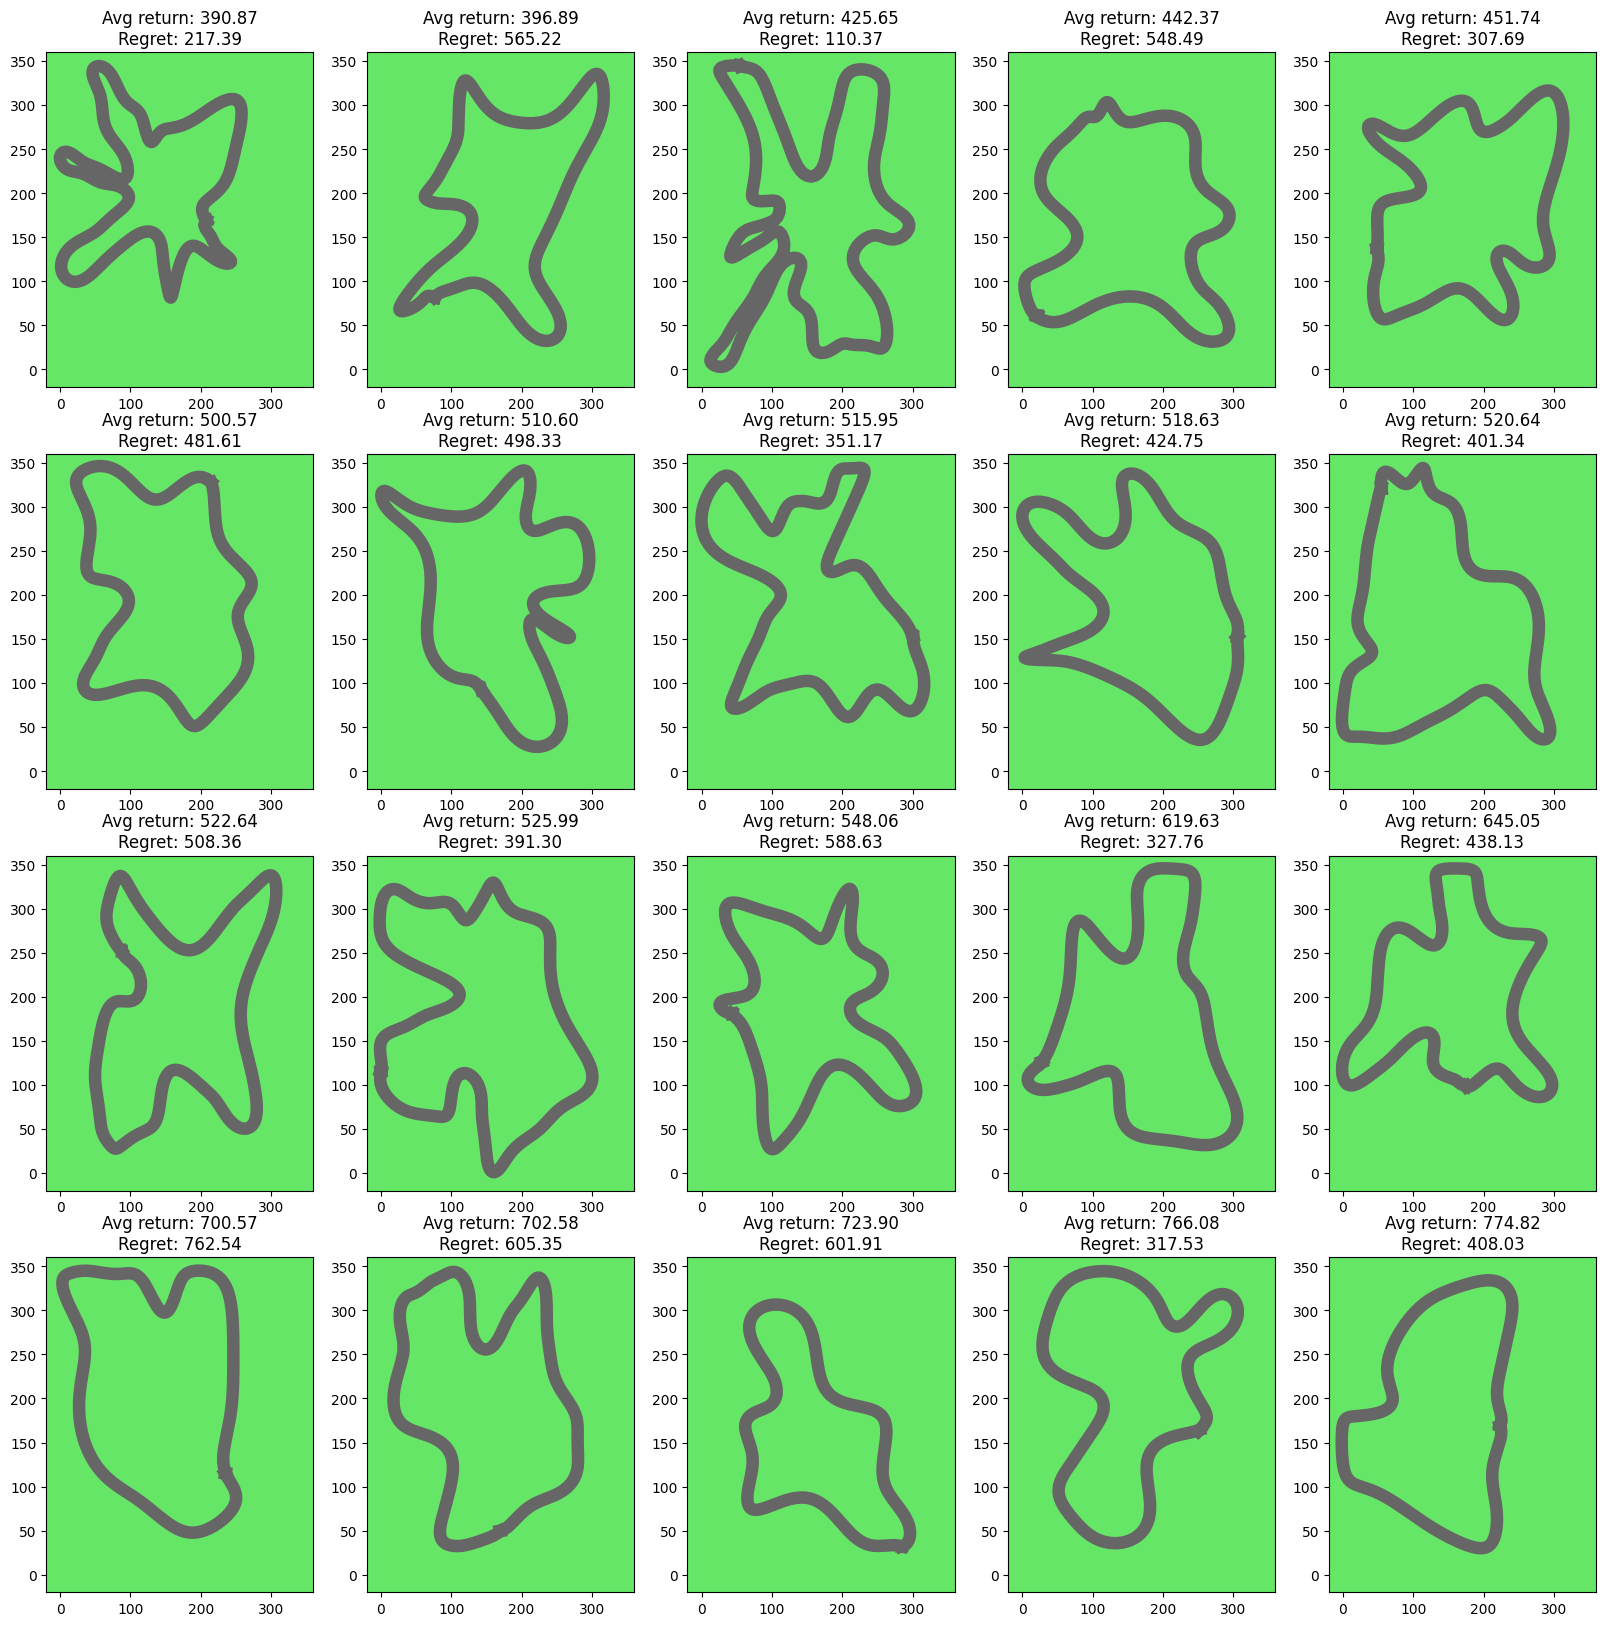

In [27]:
plt.figure(figsize=(20,20))

for i, index in enumerate(indices):
    plt.subplot(4,5,i+1)
    track = generate_track(vae, track_vectors[index])
    plot_track(track)
    plt.title(f"Avg return: {return_mean[index]:.2f}\nRegret: {regret[index]:.2f}")